In [1]:
#Core Python, Pandas, and kaldi_io
import numpy as np
import pandas as pd
import string
from collections import Counter
import kaldi_io

#Scikit
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances,average_precision_score
from sklearn.metrics.pairwise import pairwise_kernels
from scipy import stats
from scipy.spatial.distance import pdist

#Plotting
from matplotlib import pyplot as plt
import seaborn as sns



#Torch and utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader,random_split,ConcatDataset

#Import User defined classes
from data_helpers import DataHelper
from models import SimpleNet
from train_test_helpers import accuracy,train_model,evaluate_model,evaluate_model_paper,test_model,plot_learning_curves

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
load_list = ['Data/feats_cmvn.ark']
#number_list = [9,12,14,18,21,25,27,28]
#load_list = ['Data/raw_mfcc_AMI_Segments.%d.scp'%(number) for number in number_list]
num_examples = np.Inf
#num_examples = 10000

In [4]:
dh = DataHelper(load_list,num_examples)
dh.load_data(char_threshold = 5, frequency_bounds = (5,np.Inf))
dh.process_data()
c,word_to_num,num_to_word = dh.generate_key_dicts()

Length before filtering on char length 317927
Length after filtering on char length 173657
Length before filtering on frequency_bounds 173657
Length after filtering on frequency_bounds 162522
Finished Loading the Data, 162522 examples
Number of Unique words  3280


In [5]:
inputs,labels = dh.give_inputs_and_labels()
del dh

In [6]:
print(c)

Counter({'thats': 1682, 'right': 1673, 'think': 1378, 'because': 1329, 'maybe': 1271, 'mmhmm': 1264, 'something': 1205, 'about': 1088, 'remote': 1081, 'buttons': 967, 'control': 913, 'really': 885, 'actually': 839, 'should': 825, 'thing': 821, 'people': 816, 'button': 809, 'things': 788, 'there': 765, 'design': 745, 'different': 744, 'probably': 729, 'which': 664, 'meeting': 658, 'could': 632, 'alright': 622, 'screen': 618, 'three': 598, 'would': 562, 'channel': 546, 'going': 539, 'point': 535, 'gonna': 531, 'first': 523, 'colour': 512, 'quite': 507, 'stuff': 503, 'still': 490, 'other': 484, 'rubber': 472, 'doesnt': 470, 'these': 468, 'little': 461, 'project': 461, 'recognition': 456, 'functions': 448, 'guess': 447, 'interface': 447, 'sorry': 445, 'those': 444, 'simple': 442, 'product': 441, 'important': 439, 'basically': 430, 'market': 429, 'whatever': 422, 'problem': 416, 'theres': 415, 'minutes': 408, 'anything': 406, 'looking': 404, 'speech': 401, 'volume': 401, 'cause': 401, 'alre

In [25]:
for word,num in word_to_num.items():
    print(word,num)

mmhmm 0
thank 1
uhhuh 2
already 3
analyse 4
analysis 5
another 6
anyway 7
because 8
before 9
button 10
child 11
clearly 12
colours 13
control 14
corporate 15
could 16
device 17
different 18
discourse 19
doesnt 20
exactly 21
greater 22
headsets 23
heavily 24
instructions 25
language 26
looked 27
meeting 28
mention 29
mustnt 30
number 31
numbers 32
occurs 33
percent 34
pistol 35
places 36
possible 37
probably 38
problem 39
programme 40
prominent 41
promoting 42
pushbuttons 43
refers 44
regular 45
right 46
scores 47
sense 48
shape 49
short 50
should 51
since 52
something 53
station 54
stuff 55
thing 56
think 57
trick 58
trying 59
yellow 60
bluetooth 61
especially 62
playdoh 63
shortcuts 64
thursday 65
titaniumcoloured 66
abstract 67
achieve 68
autumn 69
battery 70
biased 71
bring 72
browse 73
clear 74
close 75
collect 76
definite 77
definition 78
either 79
expensive 80
flexible 81
guess 82
happens 83
identified 84
interpretation 85
kinda 86
little 87
meetings 88
mister 89
options 90
proje

colourful 831
company 832
curved 833
decision 834
defeat 835
directory 836
emission 837
examples 838
false 839
findings 840
flipopen 841
fluorescent 842
format 843
forty 844
frequencies 845
front 846
honestly 847
house 848
illuminate 849
individually 850
instance 851
interference 852
issues 853
living 854
longlife 855
meets 856
movement 857
movie 858
newer 859
often 860
particularly 861
popup 862
possibility 863
prefer 864
prepare 865
presentation 866
previous 867
provision 868
recognise 869
record 870
reviewed 871
rotated 872
scheme 873
second 874
security 875
shocking 876
shoes 877
started 878
straight 879
summary 880
technology 881
teletext 882
total 883
trendwatcher 884
trendy 885
update 886
usability 887
utterance 888
weeks 889
whenever 890
while 891
youve 892
alternatively 893
euros 894
franz 895
apply 896
blank 897
booklet 898
contained 899
effectively 900
helps 901
immediately 902
ordered 903
otherwise 904
pieces 905
planning 906
queue 907
seconds 908
service 909
shows 910
targ

retain 1535
samples 1536
sensor 1537
skinny 1538
smooth 1539
source 1540
stable 1541
stuck 1542
styles 1543
suggested 1544
supply 1545
thirdly 1546
transmitter 1547
usage 1548
wireless 1549
younger 1550
engineering 1551
extend 1552
fallen 1553
meanwhile 1554
neither 1555
soandso 1556
upgrade 1557
walks 1558
integrate 1559
inventories 1560
never 1561
satisfaction 1562
secret 1563
straightforward 1564
tells 1565
unity 1566
written 1567
consistency 1568
attributes 1569
coaches 1570
costly 1571
experiences 1572
programmability 1573
progressive 1574
protecting 1575
stations 1576
sturdy 1577
tendency 1578
changeable 1579
escalation 1580
generally 1581
holder 1582
operations 1583
stand 1584
startup 1585
unlucky 1586
whoops 1587
agreement 1588
amazing 1589
bling 1590
clearer 1591
collaborate 1592
crazy 1593
expect 1594
fantastic 1595
mistake 1596
mistakes 1597
satisfied 1598
worried 1599
phillips 1600
compress 1601
conspiracy 1602
definitions 1603
dwarf 1604
hated 1605
incredibly 1606
influenc

circuitry 2684
democratic 2685
lowest 2686
panes 2687
personalised 2688
sells 2689
sideways 2690
submenus 2691
supplement 2692
mainly 2693
poorly 2694
reference 2695
absorp 2696
disply 2697
dodgy 2698
safety 2699
amplitude 2700
flips 2701
compared 2702
efficiently 2703
kitchen 2704
selfcontained 2705
understanding 2706
teletubbies 2707
animals 2708
audience 2709
bundle 2710
common 2711
criterion 2712
discu 2713
disturbed 2714
enjoy 2715
error 2716
figured 2717
hasnt 2718
hierarchy 2719
lasting 2720
necessarily 2721
operation 2722
picked 2723
providers 2724
recurrence 2725
represented 2726
retail 2727
righthand 2728
satellite 2729
suggestions 2730
surfing 2731
tackle 2732
wheels 2733
wondered 2734
disable 2735
foreign 2736
inbetween 2737
defining 2738
fresh 2739
lemon 2740
manny 2741
adopted 2742
closer 2743
drawer 2744
effort 2745
intuitive 2746
schegloff 2747
applied 2748
classes 2749
graphics 2750
unavailable 2751
weird 2752
explanation 2753
ionized 2754
targeting 2755
delay 2756
puz

properly 3324
brings 3325
elaborate 3326
gutted 3327
signify 3328
colourblind 3329
initiating 3330
lesser 3331
paperwork 3332
zeros 3333
nicked 3334
introduces 3335
outline 3336
cordless 3337
opener 3338
horse 3339
mmmhmm 3340
turtles 3341
anticipating 3342
approachable 3343
brushed 3344
chargeable 3345
coincide 3346
commence 3347
compares 3348
complicate 3349
generates 3350
gesture 3351
independently 3352
instantly 3353
keyboar 3354
macro 3355
pilot 3356
prediscussion 3357
visibility 3358
webbased 3359
microquasars 3360
detections 3361
contains 3362
camtasia 3363
advance 3364
century 3365
halves 3366
newfangled 3367
remaining 3368
beyond 3369
corpi 3370
moves 3371
narrow 3372
official 3373
dynamically 3374
highestrated 3375
vowel 3376
constraints 3377
sixties 3378
permanent 3379
screenshot 3380
seventies 3381
ratings 3382
widely 3383
imaging 3384
jiggle 3385
manning 3386
flipboard 3387
warned 3388
bobby 3389
articulators 3390
audiences 3391
broaden 3392
challenging 3393
chrome 3394
cu

commando 3966
drats 3967
botched 3968
establish 3969
minor 3970
vision 3971
isolated 3972
maintenance 3973
estonia 3974
achieved 3975
arrays 3976
cased 3977
clients 3978
contribution 3979
crowded 3980
dependent 3981
doubled 3982
grandma 3983
impressing 3984
maximum 3985
preliminary 3986
reset 3987
sided 3988
supplied 3989
uncurved 3990
winner 3991
zones 3992
accessors 3993
appeared 3994
headphone 3995
indirectly 3996
mediates 3997
sending 3998
progressing 3999
retreat 4000
arriving 4001
yesterday 4002
stressy 4003
continue 4004
mutually 4005
protruding 4006
youth 4007
breaking 4008
produced 4009
flipscreen 4010
parents 4011
reporting 4012
variability 4013
afternoons 4014
fraid 4015
danny 4016
bonuses 4017
cancer 4018
caught 4019
elephants 4020
ground 4021
molded 4022
motif 4023
obtainable 4024
perfectionist 4025
primarily 4026
rabbits 4027
relating 4028
reliant 4029
similarity 4030
spends 4031
touchscreens 4032
vitality 4033
garfield 4034
jessy 4035
michael 4036
accommodate 4037
clarif

tutor 4646
guaranteed 4647
surprises 4648
scribble 4649
linell 4650
firefox 4651
heidi 4652
tarik 4653
alkaline 4654
finishes 4655
frustrations 4656
horrible 4657
lecturer 4658
minimal 4659
minimalistic 4660
paging 4661
popped 4662
redshifts 4663
regularly 4664
runthrough 4665
teeth 4666
upgradable 4667
useroriented 4668
whatll 4669
teammates 4670
girls 4671
indicating 4672
representational 4673
googlelike 4674
julian 4675
aesthetic 4676
aimed 4677
begins 4678
bulbs 4679
clicking 4680
conditioner 4681
conten 4682
determined 4683
devised 4684
finalised 4685
hideous 4686
preset 4687
priorities 4688
receptor 4689
remembers 4690
repeated 4691
schematic 4692
selfintuitive 4693
stolen 4694
whittaker 4695
terminal 4696
uptranslation 4697
reject 4698
keckers 4699
ceiling 4700
student 4701
wonders 4702
configured 4703
transferring 4704
ensure 4705
observatory 4706
doublecurve 4707
routines 4708
ballshaped 4709
powerstick 4710
allows 4711
borrow 4712
capacities 4713
complain 4714
degrees 4715
ed

fixing 5280
fortunate 5281
grouped 5282
negation 5283
presenter 5284
senor 5285
settee 5286
spongys 5287
terrible 5288
yellows 5289
eleventh 5290
darker 5291
swoop 5292
fusing 5293
activity 5294
dingy 5295
largest 5296
dispose 5297
elevens 5298
groupings 5299
highs 5300
instinct 5301
mixture 5302
roommate 5303
strongest 5304
whose 5305
renals 5306
sneaks 5307
splitter 5308
transcriptions 5309
limiteded 5310
coconut 5311
facto 5312
francine 5313
clumsy 5314
investigations 5315
manufacture 5316
monitors 5317
pointy 5318
scroller 5319
ultimately 5320
handshake 5321
creativ 5322
arise 5323
trendwatch 5324
altering 5325
attended 5326
customised 5327
engineercentred 5328
homes 5329
projected 5330
purchase 5331
reliability 5332
upward 5333
referenced 5334
scratchy 5335
subscript 5336
truly 5337
circumventing 5338
nicer 5339
postprocess 5340
seventh 5341
nijmegen 5342
robert 5343
aftersales 5344
allergic 5345
alphabet 5346
backing 5347
downward 5348
encodes 5349
inspirational 5350
interoperabi

margin 5951
recei 5952
replaceable 5953
solutions 5954
userspecified 5955
windowing 5956
specifying 5957
grasp 5958
survive 5959
washing 5960
repair 5961
france 5962
seiko 5963
assembly 5964
contributing 5965
cursor 5966
customdesigned 5967
factory 5968
glance 5969
prongs 5970
rathe 5971
scrollbuttons 5972
thingies 5973
toolkit 5974
beautifully 5975
segmentaton 5976
lining 5977
francino 5978
september 5979
admittedly 5980
economic 5981
progra 5982
succeed 5983
unlimited 5984
accuracy 5985
blows 5986
deactivate 5987
decor 5988
pleasure 5989
tieup 5990
hangs 5991
tagging 5992
frequented 5993
italy 5994
airplanes 5995
claims 5996
learnt 5997
rotate 5998
slideshow 5999
tweak 6000
bleeps 6001
steven 6002
opendomain 6003
decimal 6004
basing 6005
synchronization 6006
applications 6007
cloak 6008
contro 6009
creatures 6010
flipped 6011
hovering 6012
impractical 6013
innova 6014
objectives 6015
staring 6016
vantage 6017
visitors 6018
subsegments 6019
ontologies 6020
twente 6021
grouping 6022
en

donts 6650
donkey 6651
exhibit 6652
luxurous 6653
misplace 6654
stroke 6655
lending 6656
england 6657
activating 6658
batch 6659
bursts 6660
clarifications 6661
differe 6662
minimalized 6663
bananarama 6664
latino 6665
progressions 6666
rollsroyce 6667
apologise 6668
bussing 6669
deployed 6670
extensible 6671
extraordinaire 6672
individuals 6673
liberty 6674
maximise 6675
passage 6676
shuts 6677
steel 6678
flagged 6679
caroline 6680
checkers 6681
bananabando 6682
celebrity 6683
communicates 6684
delivered 6685
dozens 6686
stats 6687
weighing 6688
brussels 6689
amsterdam 6690
allergy 6691
cheating 6692
corny 6693
cribs 6694
generations 6695
hesitant 6696
liberally 6697
overruns 6698
reall 6699
utilise 6700
assorted 6701
anita 6702
unknowns 6703
token 6704
leader 6705
brackets 6706
changers 6707
classi 6708
competitive 6709
incurred 6710
loses 6711
peopleve 6712
reassurance 6713
shaking 6714
swear 6715
ambiguity 6716
heads 6717
diary 6718
practicalwise 6719
bounces 6720
neighbourhood 672

silvery 7292
approximation 7293
attitude 7294
disabling 7295
inaccurate 7296
intricacies 7297
manufactural 7298
nationalism 7299
orchestra 7300
withstanding 7301
courtneys 7302
doublesided 7303
uttered 7304
whichd 7305
deliverables 7306
clown 7307
fiable 7308
polarization 7309
possessed 7310
pulling 7311
sidewords 7312
communicated 7313
itsel 7314
onesided 7315
superb 7316
hectic 7317
dinge 7318
drawback 7319
families 7320
quivering 7321
varies 7322
abandon 7323
adobe 7324
conservative 7325
evolution 7326
twenties 7327
terrified 7328
articulation 7329
banned 7330
combat 7331
curvable 7332
dealt 7333
squishing 7334
translucent 7335
algorithmic 7336
enemies 7337
faculties 7338
softens 7339
anxiety 7340
pedros 7341
cheerful 7342
overlook 7343
personalising 7344
piranha 7345
ports 7346
shaping 7347
angst 7348
italians 7349
jirun 7350
enviro 7351
holster 7352
socioeconomic 7353
voiceactivated 7354
wealth 7355
suffer 7356
twendag 7357
consu 7358
dispense 7359
industrati 7360
intercept 7361
s

mature 8015
photos 8016
sayin 8017
unscrew 8018
ecologists 8019
windowsbased 8020
deconstructed 8021
innos 8022
mouldable 8023
stamped 8024
stocks 8025
userface 8026
merlin 8027
amplified 8028
circling 8029
embossed 8030
endurable 8031
generous 8032
implied 8033
protogalactic 8034
consum 8035
decoding 8036
effec 8037
knock 8038
multilevel 8039
participated 8040
trapped 8041
dolby 8042
chocolates 8043
engine 8044
fatten 8045
syntactic 8046
transist 8047
alrigh 8048
ambiguities 8049
cumbersome 8050
dumped 8051
insured 8052
island 8053
recordings 8054
specialty 8055
swiftly 8056
anothers 8057
audiovisual 8058
compressed 8059
electrocuted 8060
kingsize 8061
primates 8062
stain 8063
swimmingly 8064
maroon 8065
attracted 8066
mockups 8067
releasing 8068
steadily 8069
studio 8070
fruitminded 8071
junky 8072
polygon 8073
appleve 8074
daunting 8075
pausing 8076
remains 8077
screws 8078
bummer 8079
spectacular 8080
companyll 8081
pinging 8082
recommendations 8083
screams 8084
specialists 8085
ch

miracle 8674
straightaway 8675
toolman 8676
brilliance 8677
prevented 8678
cubicle 8679
grandfather 8680
hashes 8681
checkout 8682
focussi 8683
napkin 8684
rounder 8685
teaser 8686
template 8687
webbed 8688
enabled 8689
hopef 8690
rights 8691
amanda 8692
woohoo 8693
flase 8694
login 8695
radium 8696
shorten 8697
stents 8698
exposed 8699
sugges 8700
veggie 8701
inverts 8702
sensitivity 8703
shoddy 8704
subtractive 8705
thesis 8706
cheapend 8707
quantify 8708
scissors 8709
swallowing 8710
titan 8711
tripping 8712
cancellation 8713
logon 8714
plast 8715
costefficient 8716
paperweight 8717
buttonless 8718
doodled 8719
manipulated 8720
otherwi 8721
discursive 8722
finegrainedness 8723
solids 8724
squat 8725
daylight 8726
speculation 8727
bureau 8728
dispatching 8729
familys 8730
finalising 8731
harmless 8732
headphones 8733
ignoring 8734
joking 8735
memories 8736
puzzled 8737
redesigned 8738
supervising 8739
unusually 8740
unzipping 8741
petre 8742
pushbut 8743
steves 8744
toffs 8745
cranes

tiered 9316
warming 9317
cares 9318
complexes 9319
exploit 9320
frameworks 9321
jingle 9322
oscillating 9323
projoct 9324
downloads 9325
universe 9326
metropolitan 9327
projector 9328
subtract 9329
sarahs 9330
cartoons 9331
debriefing 9332
divisions 9333
sebas 9334
decis 9335
followi 9336
ignorant 9337
whens 9338
defending 9339
killer 9340
presentat 9341
refill 9342
handin 9343
gaurav 9344
architecture 9345
grill 9346
lover 9347
neededs 9348
observing 9349
presentatio 9350
reflected 9351
teaches 9352
upperlevel 9353
beige 9354
signaller 9355
tease 9356
facets 9357
reassuring 9358
multimodal 9359
nonremotelooking 9360
scuba 9361
triangleish 9362
industr 9363
youself 9364
oughta 9365
passwords 9366
selfish 9367
directories 9368
prizes 9369
rooster 9370
selfdestructible 9371
sniff 9372
weaknesses 9373
alongside 9374
clipart 9375
disability 9376
hardish 9377
introductory 9378
contrived 9379
greasy 9380
showview 9381
flare 9382
funded 9383
ovoidal 9384
rescale 9385
subsections 9386
centrali

In [6]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [7]:
#earlier random_state=42

In [8]:
x_trainval,x_test,y_trainval,y_test = train_test_split(inputs, labels, test_size=0.2, random_state=32)
x_train,x_val,y_train,y_val = train_test_split(x_trainval,y_trainval,test_size =0.25, random_state = 32)

In [9]:
x_train,y_train = torch.tensor(x_train,dtype= torch.float),torch.tensor(y_train, dtype= torch.float)
x_val,y_val = torch.tensor(x_val, dtype= torch.float),torch.tensor(y_val, dtype= torch.float)
x_test,y_test = torch.tensor(x_test, dtype= torch.float),torch.tensor(y_test, dtype= torch.float)
print(x_train.shape,y_train.shape)
print(x_val.shape,y_val.shape)
print(x_test.shape,y_test.shape)

torch.Size([3129, 40, 100]) torch.Size([3129])
torch.Size([1044, 40, 100]) torch.Size([1044])
torch.Size([1044, 40, 100]) torch.Size([1044])


In [10]:
x_train[20].squeeze()[0]

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, 27.8186, 28.0654, 28.2299, 26.7493, 24.9395,
        30.4510, 29.5461, 22.8830, 16.0730, 10.2605,  8.6571, 10.8618, 12.4652,
        15.2713, 26.6670, 32.8531, 35.5107, 36.2799, 36.4198, 36.1401, 36.0002,
        33.6224, 29.8752, 32.0139, 32.4335, 32.0839, 31.6849, 32.0139, 29.4639,
        33.7623, 32.7133, 35.6505, 31.1913, 24.7750, 18.8790, 17.2756, 19.0794,
        20.2820, 27.7364, 29.2171, 31.3559, 31.9317, 30.5332, 25.4331, 21.4846,
        10.2605,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

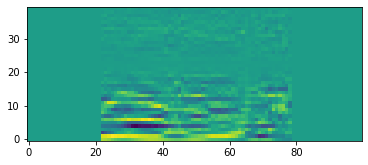

In [11]:
plt.imshow(x_train[780].squeeze(), origin = "bottom")

In [11]:
#del x_train,y_train,x_val,y_val

In [12]:
bs = 64
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, pin_memory = True, drop_last = True)

val_ds = TensorDataset(x_val, y_val)
val_dl = DataLoader(val_ds, batch_size=bs, pin_memory = True, drop_last = True)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs, pin_memory = True, drop_last = True)

In [19]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv1d(40,96,(10))
        self.pool = nn.MaxPool1d(3)
        self.conv2 = nn.Conv1d(96, 96, (8))
        #self.fc1 = nn.Linear(1728, 1024)
        self.fc1 = nn.Linear(672, 1024)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print('Pre')
        #print(x.shape)  
        x = x.view(x.shape[0], -1)
        #print('Post')
        #print(x.shape)
        x = F.relu(self.fc1(x))
        return x
    
    def give_embeddings(self,x,dev):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print('Pre')
        #print(x.shape)  
        x = x.view(x.shape[0], -1)
        #print('Post')
        #print(x.shape)
        x = F.relu(self.fc1(x))
        return x.cpu().detach().numpy() if dev.type == 'cuda' else x.detach().numpy()

In [20]:
net = SimpleNet()
net = net.float()
net.to(dev)

SimpleNet(
  (conv1): Conv1d(40, 96, kernel_size=(10,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(96, 96, kernel_size=(8,), stride=(1,))
  (fc1): Linear(in_features=672, out_features=1024, bias=True)
)

In [14]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
train = False
num_epochs = 10

In [16]:
hist = None
if train:
    hist = train_model(net,num_epochs,train_dl,val_dl,optimizer,criterion,dev,save_path="./temp/",verbose = True)
else:
    print('Not training the model')

Not training the model


In [17]:
if train:
    plot_learning_curves(hist, name = 'learning_curves_new_AMI.png')

In [10]:
#Load the best model
best_model_path = "./Models/awe_best_model.pth"
net.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [11]:
print('Test Accuracy of best model')
test_model(net,test_dl,dev)

Test Accuracy of best model
Test Accuracy of best model is 0.526378


tensor(0.5264, device='cuda:0')

In [19]:
evaluate_dl = DataLoader(test_ds, batch_size=1024, pin_memory = True, drop_last = False)

In [20]:
evaluate_model(net,evaluate_dl,dev)

The number of positive examples 1011805 and negative examples 602126741
Average Precision is 0.039047


In [ ]:
#evaluate_model_paper(net,evaluate_dl,show_plot = True)

End Of Training Cells

In [15]:
from sfba4.utils import alignSequences
from itertools import product
from big_phoney import BigPhoney

Using TensorFlow backend.


In [20]:
phoney = BigPhoney()

In [16]:
words = set([num_to_word[labels[i].item()] for i in range(labels.shape[0])])
train_words = set([num_to_word[y_train[i].item()] for i in range(y_train.shape[0])])
val_words = set([num_to_word[y_val[i].item()] for i in range(y_val.shape[0])])
test_words = set([num_to_word[y_test[i].item()] for i in range(y_test.shape[0])])

In [17]:
print(len(test_words))

3948


In [18]:
word_pairs = list(product(list(words),list(words)))

In [19]:
print(len(word_pairs))

67881121


In [20]:
word_pairs = [tuple(sorted(word_pair)) for word_pair in word_pairs if word_pair[0]!=word_pair[1]]

In [21]:
word_pairs = set(word_pairs)
print(len(word_pairs))

33936441


In [22]:
print(len(word_pairs))

33936441


In [57]:
print(len(word_pairs))

33936441


In [24]:
homophone_pairs = []
for word_pair in word_pairs:
    #Phonemize the words and align them
    aligned_seq1, aligned_seq2, eDistance = alignSequences.align(phoney.phonize(word_pair[0]), phoney.phonize(word_pair[1]))
    if eDistance == 0:
        homophone_pairs.append(word_pair)
print(len(homophone_pairs))   

KeyboardInterrupt: 

In [ ]:
print(len(homophone_pairs))

In [30]:
aligned_seq1, aligned_seq2, eDistance = alignSequences.align(word1[0], word2[0])

In [32]:
print(aligned_seq1,aligned_seq2,eDistance)

diary diary 0


In [23]:
words_df = pd.DataFrame({"word1": list(word1), "word2": list(word2)})

In [24]:
words_df.to_csv('words.txt', index = False, header = False)
#words_df.to_csv('words1.txt', index = False, header = False)

In [22]:
from sfba4.utils import *
import sys

In [27]:
! python phonemicExpansion -iFile words1.txt -wid 0 -oFile result.txt -cid 0 -compIndexPhonemes 1 -d ","

python: can't open file 'phonemicExpansion': [Errno 2] No such file or directory


In [19]:
homophone_list = [("air","heir"),("aisle","isle")]

In [20]:
homophone_list = []
with open('homophone_list.txt') as fp:
    lines = fp.readlines()
    for line in lines:
        words = line.strip(" \n").split(",")
        words = [word.strip(" ") for word in words]
        homophone_list.append((words[0],words[1]))
        

In [21]:
print(homophone_list)

[('accessary', 'accessory'), ('ad', 'add'), ('ail', 'ale'), ('air', 'heir'), ('aisle', "I'll"), ('all', 'awl'), ('allowed', 'aloud'), ('alms', 'arms'), ('altar', 'alter'), ('arc', 'ark'), ("aren't", 'aunt'), ('ate', 'eight'), ('auger', 'augur'), ('auk', 'orc'), ('aural', 'oral'), ('away', 'aweigh'), ('awe', 'oar'), ('axel', 'axle'), ('aye', 'eye'), ('bail', 'bale'), ('bait', 'bate'), ('baize', 'bays'), ('bald', 'bawled'), ('ball', 'bawl'), ('band', 'banned'), ('bard', 'barred'), ('bare', 'bear'), ('bark', 'barque'), ('baron', 'barren'), ('base', 'bass'), ('bay', 'bey'), ('bazaar', 'bizarre'), ('be', 'bee'), ('beach', 'beech'), ('bean', 'been'), ('beat', 'beet'), ('beau', 'bow'), ('beer', 'bier'), ('bel', 'bell'), ('berry', 'bury'), ('berth', 'birth'), ('bight', 'bite'), ('billed', 'build'), ('bitten', 'bittern'), ('blew', 'blue'), ('bloc', 'block'), ('boar', 'bore'), ('board', 'bored'), ('boarder', 'border'), ('bold', 'bowled'), ('boos', 'booze'), ('born', 'borne'), ('bough', 'bow'), (

In [22]:
for i,(word1,word2) in enumerate(homophone_list):
    
    #print(word1,word2)
    
    verbose = False
    if verbose:

        if word1 in train_words:
            print("%s in train words"%(word1))
        if word1 in val_words:
            print("%s in val words"%(word1))
        if word1 in test_words:
            print("%s in test words"%(word1))

        if word2 in train_words:
            print("%s in train words"%(word2))
        if word2 in val_words:
            print("%s in val words"%(word2))
        if word2 in test_words:
            print("%s in test words"%(word2))
        
    word1_in_data = word1 in train_words or word1 in val_words or word1 in test_words
    word2_in_data = word2 in train_words or word2 in val_words or word2 in test_words
    
    if (word1_in_data) and (word2_in_data):
        print('Homophone %d in data'%(i))

Homophone 47 in data
Homophone 57 in data
Homophone 71 in data
Homophone 89 in data
Homophone 124 in data
Homophone 148 in data
Homophone 286 in data
Homophone 295 in data
Homophone 302 in data
Homophone 366 in data
Homophone 383 in data
Homophone 384 in data
Homophone 421 in data


In [23]:
def present_in_data(word):
    return word in train_words or word in val_words or word in test_words

In [24]:
homophone_list = list(filter(lambda x: present_in_data(x[0]) and present_in_data(x[1]), homophone_list))

In [25]:
homophone_list

[('board', 'bored'),
 ('brake', 'break'),
 ('caught', 'court'),
 ('coarse', 'course'),
 ('farther', 'father'),
 ('forth', 'fourth'),
 ('peace', 'piece'),
 ('plain', 'plane'),
 ('principal', 'principle'),
 ('steal', 'steel'),
 ('there', 'their'),
 ('threw', 'through'),
 ('weather', 'whether')]

In [26]:
visualization_ds = TensorDataset(torch.tensor(inputs,dtype= torch.float),torch.tensor(labels, dtype= torch.float))
visualization_dl = DataLoader(visualization_ds, batch_size=1024, pin_memory = True, drop_last = False)

In [27]:
def nearest_neighbors(net,visualization_dl,n_neighbors = 3):
    
    embeddings = None
    labels = None
    
    for xb,yb in visualization_dl:
        #If device is GPU move features to GPU
        if dev.type == 'cuda' and not xb.is_cuda:
            xb = xb.to(dev, non_blocking=True)
            
        #Get the embeddings
        batch_embeddings = net(xb).cpu().detach().numpy()
        
        #Add to the main embeddings
        if embeddings is not None:
            embeddings = np.vstack((embeddings, batch_embeddings))
        else:
            embeddings = batch_embeddings
    
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree',metric = 'euclidean', n_jobs = 4).fit(embeddings)
    distances,indices = nbrs.kneighbors(embeddings)
    
    return distances,indices
    

In [28]:
def nearest_neighbors_for_word_old(word,indices,labels):
    
    num_list = [word_to_num[word]]
    ids = np.where(np.isin(labels,np.array(num_list)))
    neighbor_indices = indices[ids]
    
    for i in range(neighbor_indices.shape[0]):
        neighboring_words = [num_to_word[labels[neighbor_indices[i,j]]] for j in range(neighbor_indices.shape[1])]
        print(neighboring_words)
    

In [ ]:
def nearest_neighbors_for_word(word,indices,labels):
    
    num_list = [word_to_num[word]]
    ids = np.where(np.isin(labels,np.array(num_list)))
    neighbor_indices = indices[ids]
    
    for i in range(neighbor_indices.shape[0]):
        neighboring_words = [num_to_word[labels[neighbor_indices[i,j]]] for j in range(neighbor_indices.shape[1])]
        print(neighboring_words)
    

In [29]:
distances,indices = nearest_neighbors(net,visualization_dl,n_neighbors = 3)

KeyboardInterrupt: 

In [56]:
def give_tsne(net,visualization_dl):
    
    embeddings = None
    for i,(xb,yb) in enumerate(visualization_dl):
        #If device is GPU move features to GPU
        if dev.type == 'cuda' and not xb.is_cuda:
            xb = xb.to(dev, non_blocking=True)
            if embeddings is not None:
                print(embeddings.shape[0])
            
        #Get the embeddings
        batch_embeddings = net.give_embeddings(xb)
        
        #Add to the main embeddings
        if embeddings is not None:
            embeddings = np.vstack((embeddings, batch_embeddings))
        else:
            embeddings = batch_embeddings
            
    tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
    tsne_vectors = tsne.fit_transform(embeddings)
    
    return tsne_vectors


In [57]:
def add_membership(word):
    train_tag = "Tr" if word in train_words else ""
    val_tag = "|Val" if word in val_words else ""
    test_tag = "|Ts" if word in test_words else ""
    return word+" (%s%s%s)"%(train_tag,val_tag,test_tag)

In [58]:
def visualize_words(word_list,tsne_vectors,labels,rigid_limits = False):
    #Get ids of words from labels
    num_list = [word_to_num[word] for word in word_list]
    ids = np.where(np.isin(labels,np.array(num_list)))
    
    df_subset = {}
    df_subset['tsne-2d-one'] = tsne_vectors[ids][:,0]
    df_subset['tsne-2d-two'] = tsne_vectors[ids][:,1]
    df_subset['Word'] = [num_to_word[labels[ids][i].item()] for i in range(ids[0].shape[0])]
    
    #Convert to dataframe
    df_subset = pd.DataFrame(df_subset)
    #Add membership tags
    df_subset['Word'] = df_subset['Word'].apply(add_membership)
    
    #print(df_subset['tsne-2d-one'].shape)
    #print(df_subset['tsne-2d-two'].shape)
    #print(len(df_subset['y']))
    
    #print(ids)
    #print(df_subset['y'])
    
    g = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Word",
    data=df_subset,
    legend="full",
    alpha=0.5)
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    if rigid_limits:
        x_coordinate = tsne_vectors[:,0]
        y_coordinate = tsne_vectors[:,1]
        epsilon = 5
        plt.xlim(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
        plt.ylim(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)
    

In [79]:
tsne_vectors = give_tsne(net,visualization_dl)

1024
2048
3072
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3449 samples in 0.641s...
[t-SNE] Computed neighbors for 3449 samples in 16.523s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3449
[t-SNE] Computed conditional probabilities for sample 2000 / 3449
[t-SNE] Computed conditional probabilities for sample 3000 / 3449
[t-SNE] Computed conditional probabilities for sample 3449 / 3449
[t-SNE] Mean sigma: 0.000507
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.913239
[t-SNE] KL divergence after 500 iterations: 1.504368


In [80]:
x_coordinate = tsne_vectors[:,0]
y_coordinate = tsne_vectors[:,1]
epsilon = 5
print(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
print(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)

-47.14128112792969 50.3733024597168
-48.8997688293457 57.878501892089844


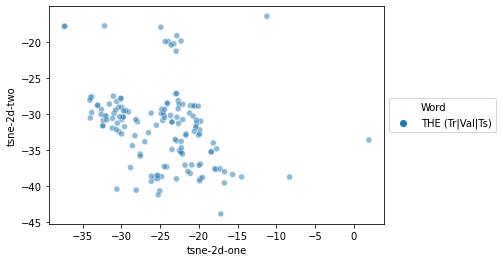

In [81]:
word_list = ["THE"]
visualize_words(word_list,tsne_vectors,labels)

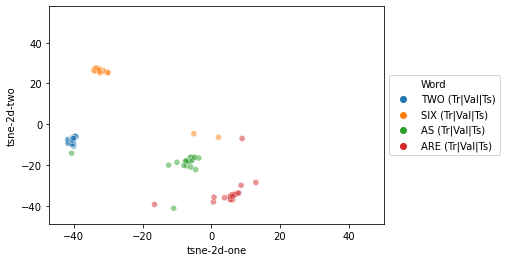

In [102]:
word_list = ["AS","ARE","TWO","SIX"]
visualize_words(word_list,tsne_vectors,labels,True)

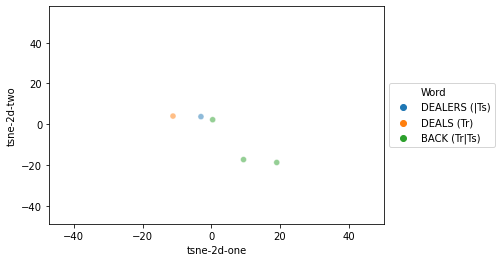

In [103]:
word_list = ["DEALERS","DEALS","BACK"]
visualize_words(word_list,tsne_vectors,labels,True)

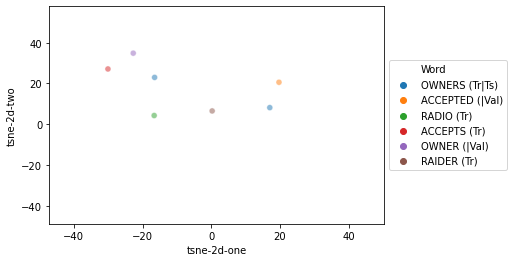

In [104]:
word_list = ["ACCEPTED","ACCEPTS","RADIO","RAIDER","OWNER","OWNERS"]
visualize_words(word_list,tsne_vectors,labels,True)

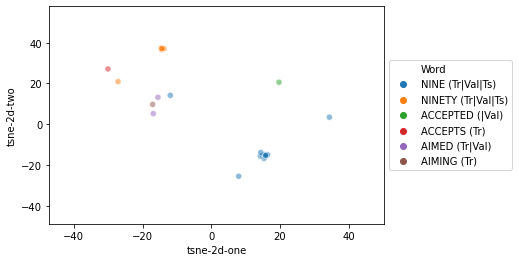

In [105]:
word_list = ["NINE","NINETY","ACCEPTED","ACCEPTS","AIMED","AIMING"]
visualize_words(word_list,tsne_vectors,labels,True)

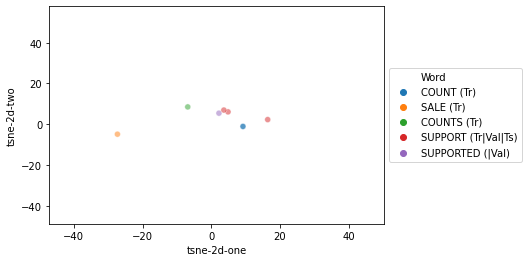

In [106]:
word_list = ["COUNT","COUNTS","SALE","SUPPORT","SUPPORTED"]
visualize_words(word_list,tsne_vectors,labels,True)

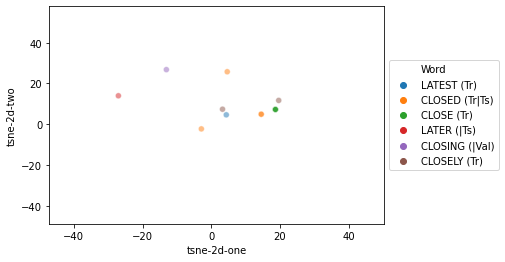

In [107]:
word_list = ["LATER","LATEST","CLOSE","CLOSING","CLOSED","CLOSELY"]
visualize_words(word_list,tsne_vectors,labels,True)

In [114]:
distances,indices = nearest_neighbors(net,torch.tensor(inputs,dtype=torch.float),labels,n_neighbors=5)

In [115]:
word = "SUPPORT"
nearest_neighbors_for_word(word,indices,labels)

['SUPPORT', 'CLIMB', 'PROBABLY', 'AIRCRAFT', 'DIRECT']
['SUPPORT', 'OPERATOR', 'AIRCRAFT', 'HOLDING', 'SHARES']
['LIKELY', 'COMING', 'OPERATOR', 'SHARES', 'SURPRISE']


In [116]:
word = "LATER"
nearest_neighbors_for_word(word,indices,labels)

['LATER', 'UNDER', 'HUNDRED', 'UNDER', 'HUNDRED']


In [117]:
word = "CLOSING"
nearest_neighbors_for_word(word,indices,labels)

['CLOSING', 'WASHINGTON', 'AFTER', 'OPPOSITION', 'COMMENT']


In [118]:
word = "ACCEPTED"
nearest_neighbors_for_word(word,indices,labels)

['ACCEPTED', 'INFLATION', 'PURCHASES', 'PROCESS', 'SPLIT']


In [119]:
word = "DEALS"
nearest_neighbors_for_word(word,indices,labels)

['DEALS', 'PUBLICLY', 'FINANCIAL', 'FINANCIAL', 'EXPOSURE']


In [120]:
word = "ACCEPTS"
nearest_neighbors_for_word(word,indices,labels)

['ACCEPTS', 'SIX', 'BUSINESS', 'SIX', 'SINCE']


In [121]:
word = "DAY"
nearest_neighbors_for_word(word,indices,labels)

['DAY', 'MAY', 'MAY', 'MAY', 'EIGHT']
['DAY', 'BIDS', 'MAY', 'DAY', 'BASED']
['DAY', 'DAY', 'MAY', 'BIDS', 'BASED']
['DAY', 'YOU', 'HUNDRED', 'UNDER', 'CLEAR']


In [122]:
word = "DEALERS"
nearest_neighbors_for_word(word,indices,labels)

['DEALERS', 'LANGUAGE', 'GROUP', 'TOO', 'PREVIOUS']
